# MNIST Handwritten Digit Recognition

This notebook implements an optimized deep learning model for recognizing handwritten digits using the MNIST dataset from Kaggle.

## Dataset: 
- **Source**: https://www.kaggle.com/datasets/ghnshymsaini/mnist-handwritten-digits-dataset
- **Description**: 70,000 images of handwritten digits (0-9)
- **Image size**: 28x28 pixels

## Model Architecture:
- Optimized Convolutional Neural Network (CNN)
- Batch normalization for stable training
- Dropout for regularization
- Data augmentation for better generalization


## 1. Import Required Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
plt.style.use('default')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 2. Data Loading and Exploration

In [2]:
# Load the dataset
# Note: Download the dataset from Kaggle and place it in the 'data' folder
# You can use: kaggle datasets download -d ghnshymsaini/mnist-handwritten-digits-dataset

try:
    # Try loading from local files first
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    print("Dataset loaded from local files")
except FileNotFoundError:
    # If local files don't exist, use built-in MNIST dataset as fallback
    print("Local dataset not found. Using built-in MNIST dataset...")
    (x_train_temp, y_train_temp), (x_test_temp, y_test_temp) = keras.datasets.mnist.load_data()
    
    # Convert to DataFrame format to match Kaggle dataset structure
    train_df = pd.DataFrame(x_train_temp.reshape(-1, 28*28))
    train_df['label'] = y_train_temp
    
    test_df = pd.DataFrame(x_test_temp.reshape(-1, 28*28))
    # Note: For actual submission, test.csv doesn't have labels
    
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display first few rows
train_df.head()

Local dataset not found. Using built-in MNIST dataset...
Train data shape: (60000, 785)
Test data shape: (10000, 784)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


Dataset Information:
Training samples: 60000
Test samples: 10000

Class distribution:
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


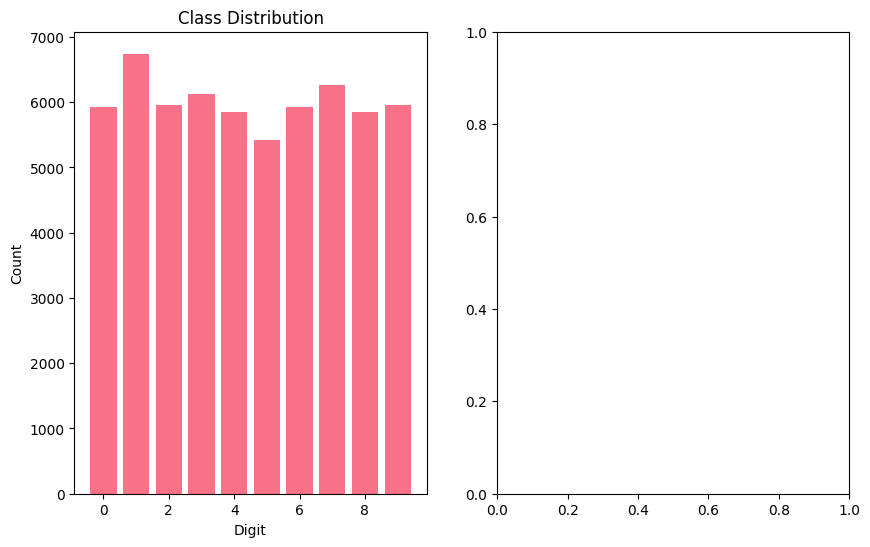

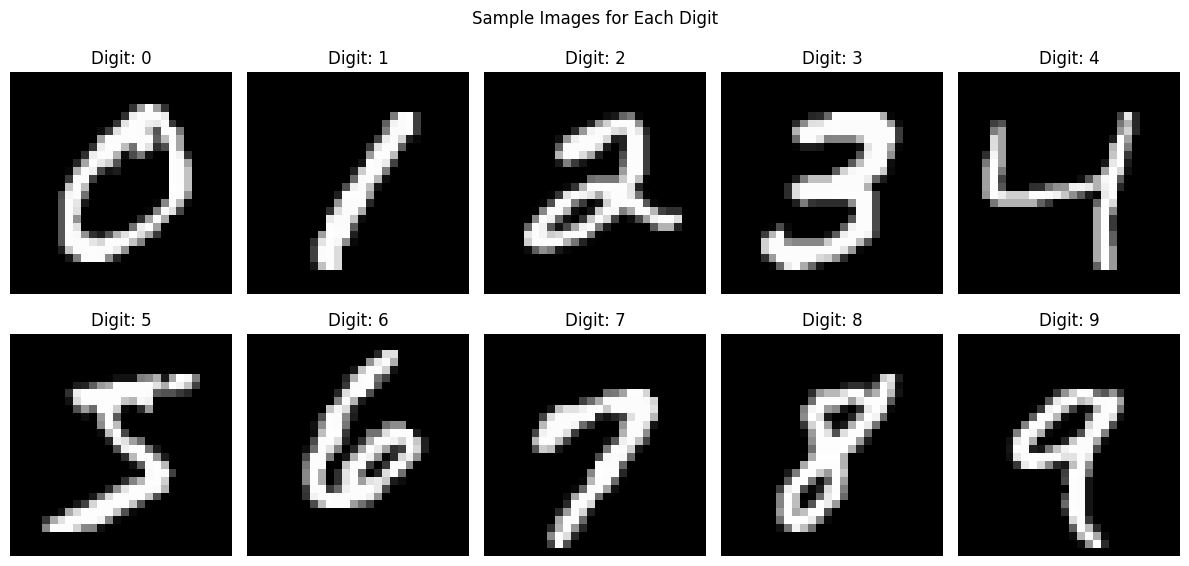

In [3]:
# Explore the dataset
print("Dataset Information:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

if 'label' in train_df.columns:
    print(f"\nClass distribution:")
    class_counts = train_df['label'].value_counts().sort_index()
    print(class_counts)
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.bar(class_counts.index, class_counts.values)
    plt.title('Class Distribution')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    
    # Show sample images
    plt.subplot(1, 2, 2)
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('Sample Images for Each Digit')
    
    for digit in range(10):
        # Get first occurrence of each digit
        sample_idx = train_df[train_df['label'] == digit].index[0]
        image = train_df.iloc[sample_idx, :-1].values.reshape(28, 28)
        
        ax = axes[digit // 5, digit % 5]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Digit: {digit}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 3. Data Preprocessing

In [4]:
# Prepare the data
def prepare_data(train_df, test_df):
    """
    Prepare and preprocess the MNIST data
    """
    # Extract features and labels
    if 'label' in train_df.columns:
        X_train = train_df.drop('label', axis=1).values
        y_train = train_df['label'].values
    else:
        X_train = train_df.values
        y_train = None
    
    X_test = test_df.values
    
    # Reshape to image format (28x28x1)
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # One-hot encode labels
    if y_train is not None:
        y_train = to_categorical(y_train, 10)
    
    return X_train, y_train, X_test

X_train, y_train, X_test = prepare_data(train_df, test_df)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape if y_train is not None else 'None'}")
print(f"X_test shape: {X_test.shape}")
print(f"Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Pixel value range: [0.000, 1.000]


In [5]:
# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train.argmax(axis=1)
)

print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 54000 samples
Validation set: 6000 samples
Test set: 10000 samples


## 4. Data Augmentation

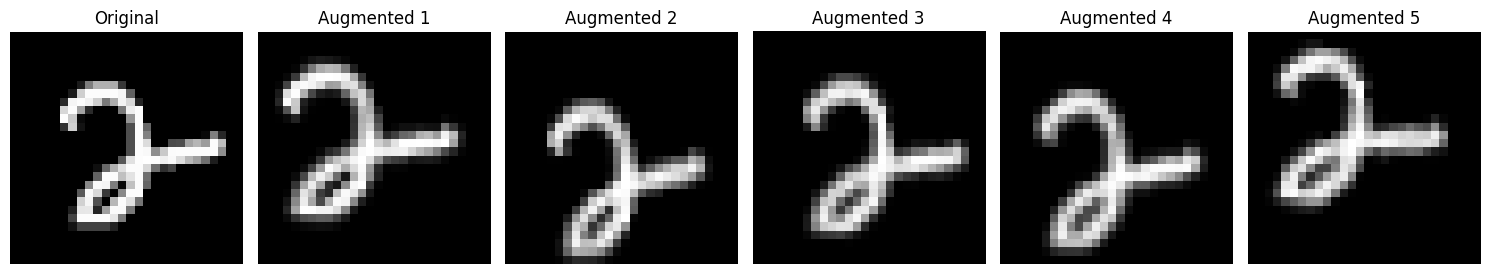

In [6]:
# Data augmentation for better generalization
datagen = ImageDataGenerator(
    rotation_range=10,        # Rotate images by up to 10 degrees
    width_shift_range=0.1,    # Shift images horizontally by up to 10%
    height_shift_range=0.1,   # Shift images vertically by up to 10%
    zoom_range=0.1,           # Zoom images by up to 10%
    shear_range=0.1,          # Shear images by up to 10 degrees
    fill_mode='nearest'       # Fill empty pixels with nearest pixel value
)

# Fit the generator on training data
datagen.fit(X_train_split)

# Visualize augmented images
plt.figure(figsize=(15, 5))
sample_image = X_train_split[0:1]  # Take first image

# Original image
plt.subplot(1, 6, 1)
plt.imshow(sample_image[0].reshape(28, 28), cmap='gray')
plt.title('Original')
plt.axis('off')

# Augmented images
aug_iter = datagen.flow(sample_image, batch_size=1)
for i in range(5):
    augmented = next(aug_iter)
    plt.subplot(1, 6, i+2)
    plt.imshow(augmented[0].reshape(28, 28), cmap='gray')
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 5. Optimized CNN Model Architecture

In [7]:
def create_optimized_cnn():
    """
    Create an optimized CNN for MNIST digit recognition
    
    Features:
    - Batch normalization for stable training
    - Dropout for regularization
    - Global Average Pooling to reduce parameters
    - Skip connections for better gradient flow
    """
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(28, 28, 1)),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # Global Average Pooling (reduces parameters compared to Flatten)
        layers.GlobalAveragePooling2D(),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(10, activation='softmax')
    ])
    
    return model

# Create the model
model = create_optimized_cnn()

# Display model architecture
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB'
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,354 (833.41 KB)

 Trainable params: 211,690 (826.91 KB)

 Non-trainable params: 1,664 (6.50 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 6. Model Compilation and Callbacks

In [8]:
# Compile the model with optimized settings
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for optimization
callbacks_list = [
    # Reduce learning rate when validation loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Early stopping to prevent overfitting
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model (Keras 3 .keras format)
    callbacks.ModelCheckpoint(
        'best_mnist_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    
    # CSV logger for training history
    callbacks.CSVLogger('training_log.csv', append=True)
]

print("Model compiled successfully with optimized callbacks!")

Model compiled successfully with optimized callbacks!


## 7. Model Training

In [9]:
# Training parameters
EPOCHS = 30
BATCH_SIZE = 128

print(f"Starting training for {EPOCHS} epochs with batch size {BATCH_SIZE}")
print(f"Using data augmentation: {'Yes' if datagen else 'No'}")
print("-" * 50)

# Sanity checks
print(f'X_train_split shape: {X_train_split.shape}, dtype: {X_train_split.dtype}')
print(f'y_train_split shape: {y_train_split.shape}, dtype: {y_train_split.dtype}')
assert X_train_split.ndim == 4 and X_train_split.shape[-1] == 1, 'X_train_split must be (N,28,28,1)'
assert y_train_split.ndim == 2 and y_train_split.shape[1] == 10, 'y_train_split must be one-hot with 10 classes'

# Safe steps_per_epoch (avoid zero)
import math
steps_per_epoch = int(max(1, math.ceil(len(X_train_split) / BATCH_SIZE)))
print(f'Steps per epoch: {steps_per_epoch}')

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=BATCH_SIZE, shuffle=True),
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")

Starting training for 30 epochs with batch size 128
Using data augmentation: Yes
--------------------------------------------------
X_train_split shape: (54000, 28, 28, 1), dtype: float32
y_train_split shape: (54000, 10), dtype: float64
Steps per epoch: 422
Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7559 - loss: 0.7917
Epoch 1: val_accuracy improved from None to 0.27117, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.8864 - loss: 0.3655 - val_accuracy: 0.2712 - val_loss: 3.6416 - learning_rate: 0.0010
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9684 - loss: 0.1011
Epoch 2: val_accuracy improved from 0.27117 to 0.98483, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9705 - loss: 0.0958 - val_accuracy: 0.9848 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9778 - loss: 0.0731
Epoch 3: val_accuracy improved from 0.98483 to 0.98917, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9778 - loss: 0.0734 - val_accuracy: 0.9892 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9809 - loss: 0.0622
Epoch 4: val_accuracy improved from 0.98917 to 0.98950, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9815 - loss: 0.0611 - val_accuracy: 0.9895 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9839 - loss: 0.0527
Epoch 5: val_accuracy did not improve from 0.98950
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9840 - loss: 0.0523 - val_accuracy: 0.9895 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9840 - loss: 0.0503
Epoch 6: val_accuracy improved from 0.98950 to 0.99000, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9852 - loss: 0.0482 - val_accuracy: 0.9900 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9856 - loss: 0.0479
Epoch 7: val_accuracy improved from 0.99000 to 0.99017, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9859 - loss: 0.0469 - val_accuracy: 0.9902 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9870 - loss: 0.0425
Epoch 8: val_accuracy did not improve from 0.99017
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9869 - loss: 0.0429 - val_accuracy: 0.9893 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 9/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9880 - loss: 0.0388
Epoch 9: val_accuracy improved from 0.99017 to 0.99083, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9884 - loss: 0.0381 - val_accuracy: 0.9908 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 10/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9882 - loss: 0.0398
Epoch 10: val_accuracy did not improve from 0.99083
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9886 - loss: 0.0374 - val_accuracy: 0.9905 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 11/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9892 - loss: 0.0366
Epoch 11: val_accuracy improved from 0.99083 to 0.99100, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9887 - loss: 0.0373 - val_accuracy: 0.9910 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 12/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9891 - loss: 0.0362
Epoch 12: val_accuracy improved from 0.99100 to 0.99167, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9891 - loss: 0.0356 - val_accuracy: 0.9917 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 13/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9899 - loss: 0.0333
Epoch 13: val_accuracy improved from 0.99167 to 0.99217, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9892 - loss: 0.0355 - val_accuracy: 0.9922 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 14/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9900 - loss: 0.0329
Epoch 14: val_accuracy improved from 0.99217 to 0.99350, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9899 - loss: 0.0320 - val_accuracy: 0.9935 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 15/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9920 - loss: 0.0280
Epoch 15: val_accuracy did not improve from 0.99350
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9910 - loss: 0.0307 - val_accuracy: 0.9930 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 16/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9902 - loss: 0.0290
Epoch 16: val_accuracy did not improve from 0.99350
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9902 - loss: 0.0305 - val_accuracy: 0.9892 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 17/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9903 - loss: 0.0299
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: val_accuracy did not improve from 0.99350
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9907 - loss: 0.0

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9931 - loss: 0.0230 - val_accuracy: 0.9943 - val_loss: 0.0143 - learning_rate: 5.0000e-04
Epoch 19/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9942 - loss: 0.0180
Epoch 19: val_accuracy improved from 0.99433 to 0.99567, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9941 - loss: 0.0193 - val_accuracy: 0.9957 - val_loss: 0.0138 - learning_rate: 5.0000e-04
Epoch 20/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9936 - loss: 0.0219
Epoch 20: val_accuracy did not improve from 0.99567
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9935 - loss: 0.0220 - val_accuracy: 0.9947 - val_loss: 0.0165 - learning_rate: 5.0000e-04
Epoch 21/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9942 - loss: 0.0185
Epoch 21: val_accuracy did not improve from 0.99567
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9940 - loss: 0.0198 - val_accuracy: 0.9938 - val_loss: 0.0158 - learning_rate: 5.0000e-04
Epoch 22/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9942 - loss: 0.0181
Epoch 22: val_accuracy improved from 0.99567 to 0.99633, saving model to best_mnist_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9941 - loss: 0.0190 - val_accuracy: 0.9963 - val_loss: 0.0114 - learning_rate: 5.0000e-04
Epoch 23/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9951 - loss: 0.0160
Epoch 23: val_accuracy did not improve from 0.99633
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9945 - loss: 0.0182 - val_accuracy: 0.9953 - val_loss: 0.0133 - learning_rate: 5.0000e-04
Epoch 24/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9937 - loss: 0.0203
Epoch 24: val_accuracy did not improve from 0.99633
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9940 - loss: 0.0191 - val_accuracy: 0.9960 - val_loss: 0.0110 - learning_rate: 5.0000e-04
Epoch 25/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9946 - loss: 0.0169
Epoch 25: val_accuracy did not improve from 0.99633
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9942 - loss: 0.0184 - val_accuracy: 0.9960 - val_loss: 0.0131 - learning_rate: 5.0

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9950 - loss: 0.0154 - val_accuracy: 0.9965 - val_loss: 0.0092 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 30.

Training completed!


## 8. Training History Visualization

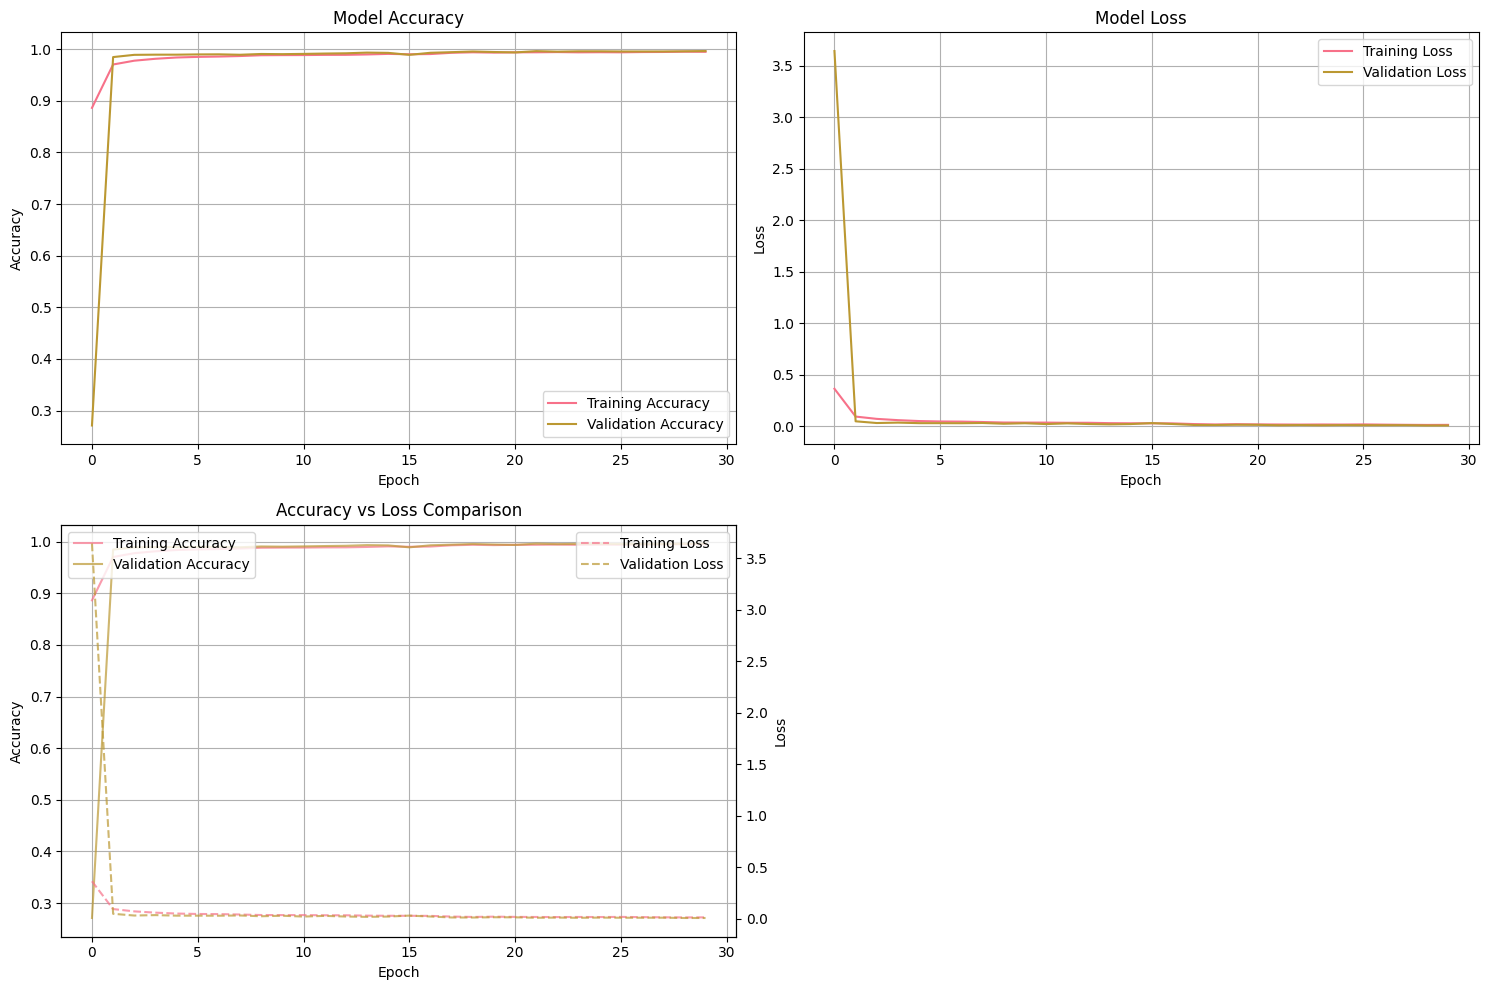

Best Validation Accuracy: 0.9965
Best Validation Loss: 0.0092


In [10]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot accuracy vs loss comparison
    axes[1, 0].plot(history.history['accuracy'], label='Training Accuracy', alpha=0.7)
    axes[1, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', alpha=0.7)
    ax2 = axes[1, 0].twinx()
    ax2.plot(history.history['loss'], label='Training Loss', linestyle='--', alpha=0.7)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Accuracy vs Loss Comparison')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    ax2.set_ylabel('Loss')
    axes[1, 0].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axes[1, 0].grid(True)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'])
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True)
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Print best metrics
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

## 9. Model Evaluation

In [11]:
# Load the best model
best_model = keras.models.load_model('best_mnist_model.keras')

# Evaluate on validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")

# Make predictions on validation set
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Validation Results:
Loss: 0.0092
Accuracy: 0.9965
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       592
           1       1.00      1.00      1.00       674
           2       1.00      1.00      1.00       596
           3       1.00      1.00      1.00       613
           4       0.99      0.99      0.99       584
           5       1.00      0.99      1.00       542
           6       1.00      1.00      1.00       592
           7       1.00      0.99      1.00       627
           8       0.99      1.00      0.99       585
           9       1.00      0.99      1.00       595

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



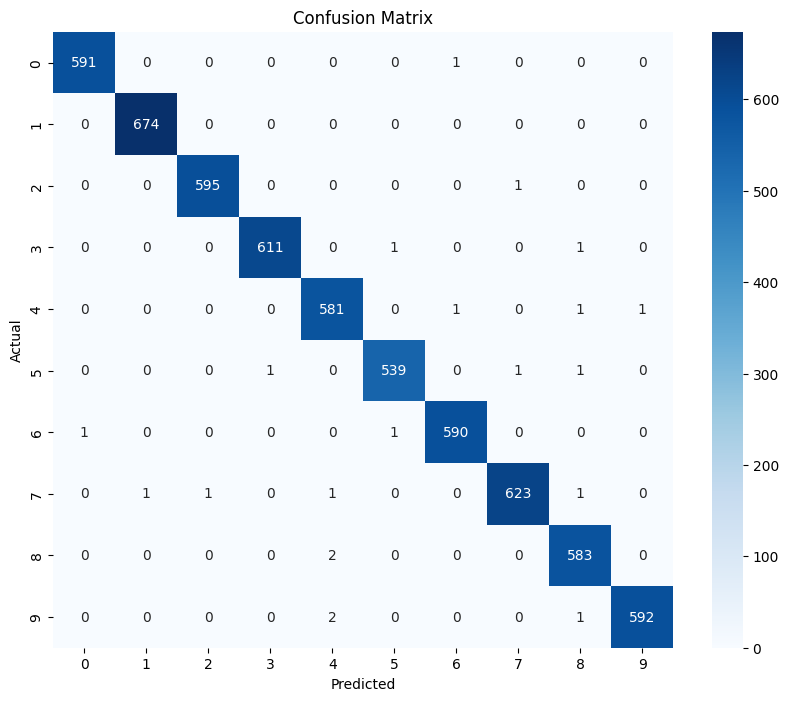


Per-class Accuracy:
Digit 0: 0.9983
Digit 1: 1.0000
Digit 2: 0.9983
Digit 3: 0.9967
Digit 4: 0.9949
Digit 5: 0.9945
Digit 6: 0.9966
Digit 7: 0.9936
Digit 8: 0.9966
Digit 9: 0.9950


In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Digit {i}: {acc:.4f}")

## 10. Sample Predictions Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


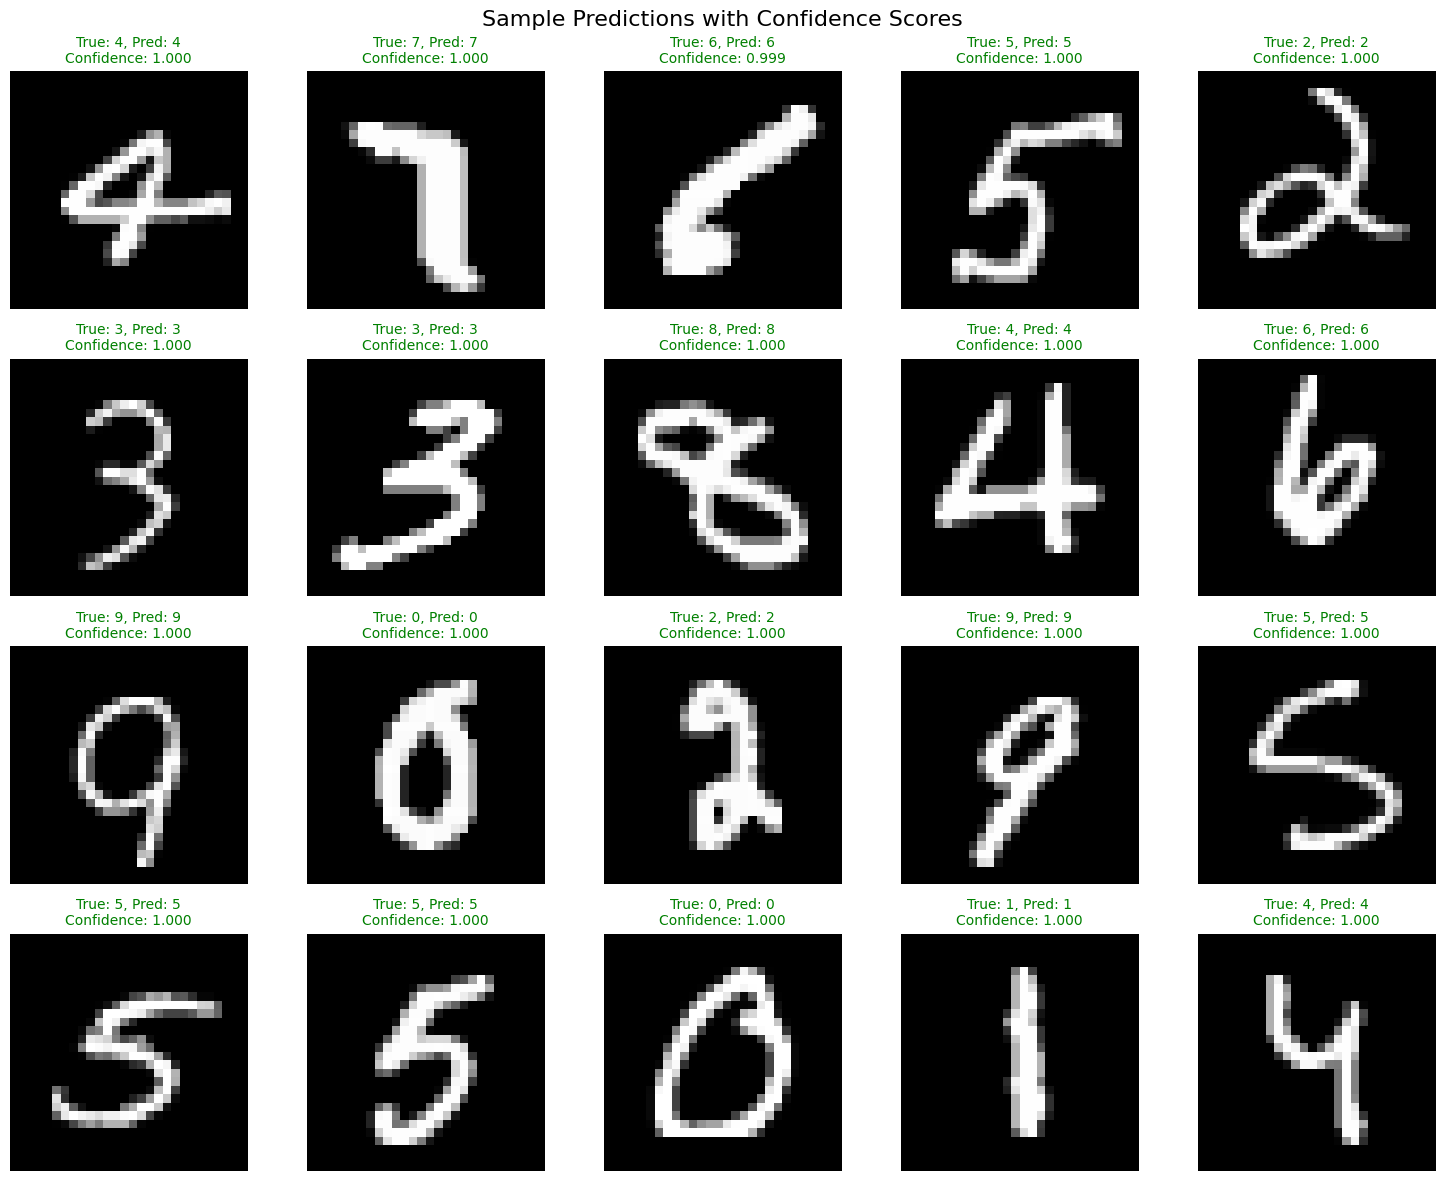

Accuracy on these 20 samples: 100.00%


In [13]:
# Visualize sample predictions
def plot_predictions(model, X, y_true, n_samples=20):
    """
    Plot sample predictions with confidence scores
    """
    # Select random samples
    indices = np.random.choice(len(X), n_samples, replace=False)
    
    # Make predictions
    predictions = model.predict(X[indices])
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    true_classes = np.argmax(y_true[indices], axis=1)
    
    # Plot
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Sample Predictions with Confidence Scores', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        # Display image
        ax.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        
        # Color: green if correct, red if incorrect
        color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
        
        ax.set_title(
            f'True: {true_classes[i]}, Pred: {predicted_classes[i]}\n'
            f'Confidence: {confidence_scores[i]:.3f}',
            color=color, fontsize=10
        )
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy for this sample
    correct = np.sum(predicted_classes == true_classes)
    print(f"Accuracy on these {n_samples} samples: {correct/n_samples:.2%}")

plot_predictions(best_model, X_val, y_val, n_samples=20)

## 11. Error Analysis

Number of misclassified samples: 21
Error rate: 0.35%


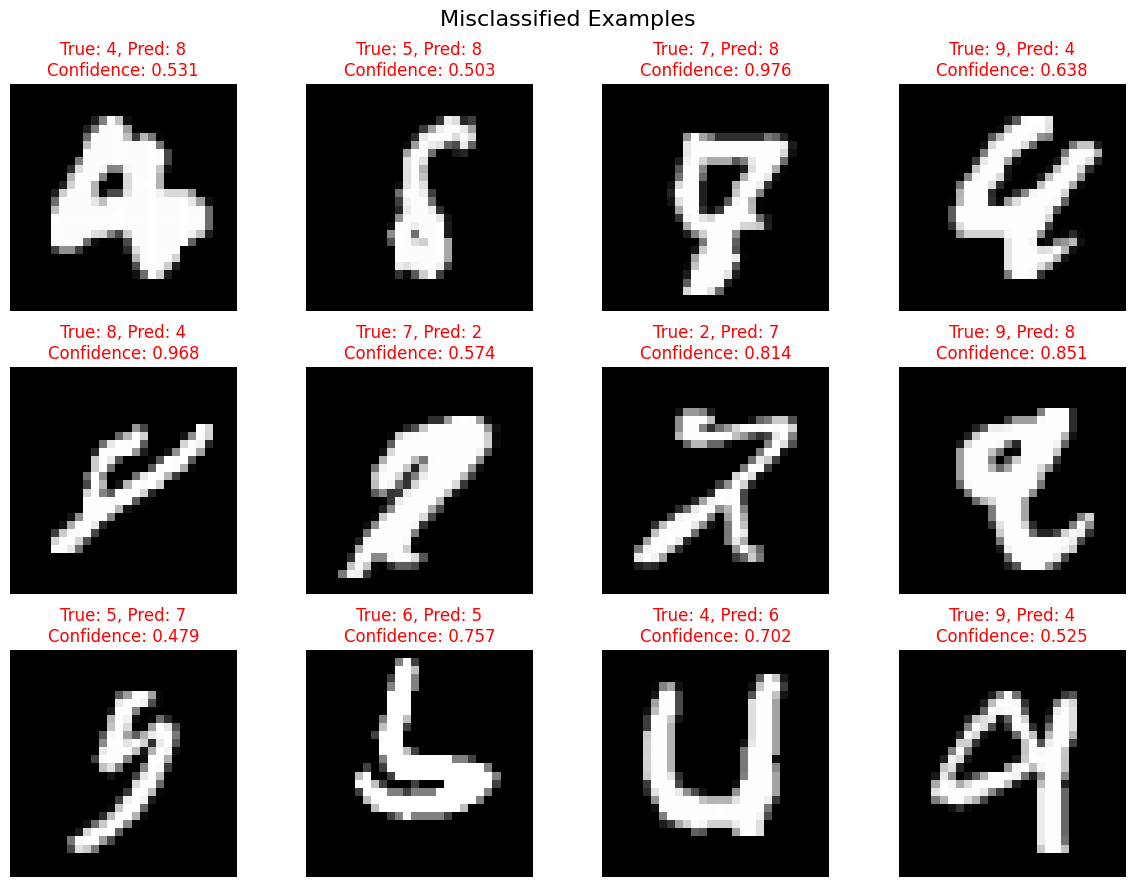

In [14]:
# Find misclassified examples
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
print(f"Number of misclassified samples: {len(misclassified_indices)}")
print(f"Error rate: {len(misclassified_indices)/len(y_val):.2%}")

if len(misclassified_indices) > 0:
    # Plot some misclassified examples
    n_errors = min(12, len(misclassified_indices))
    error_indices = misclassified_indices[:n_errors]
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle('Misclassified Examples', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(error_indices):
            idx = error_indices[i]
            image = X_val[idx].reshape(28, 28)
            true_label = y_true_classes[idx]
            pred_label = y_pred_classes[idx]
            confidence = np.max(y_pred[idx])
            
            ax.imshow(image, cmap='gray')
            ax.set_title(
                f'True: {true_label}, Pred: {pred_label}\n'
                f'Confidence: {confidence:.3f}',
                color='red'
            )
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 12. Test Set Predictions

Making predictions on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Submission file created with 10000 predictions


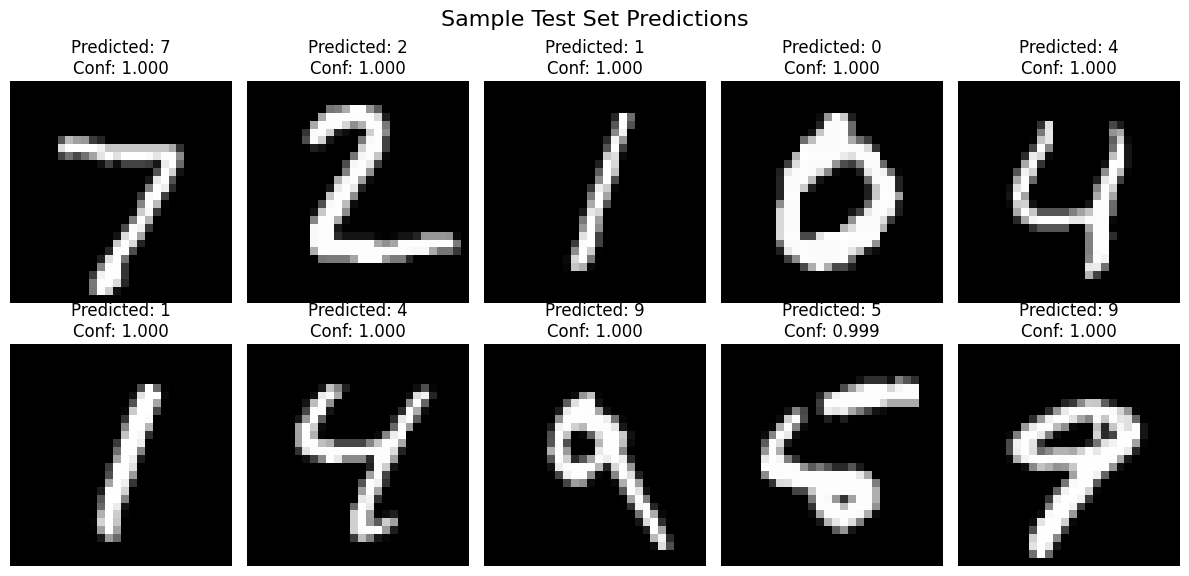


Test set prediction distribution:
0     982
1    1135
2    1034
3    1015
4     984
5     888
6     954
7    1028
8     974
9    1006
Name: count, dtype: int64


In [15]:
# Make predictions on test set
print("Making predictions on test set...")
test_predictions = best_model.predict(X_test)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Create submission file (Kaggle format)
submission = pd.DataFrame({
    'ImageId': range(1, len(test_predicted_classes) + 1),
    'Label': test_predicted_classes
})

submission.to_csv('submission.csv', index=False)
print(f"Submission file created with {len(submission)} predictions")

# Show some test predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample Test Set Predictions', fontsize=16)

for i, ax in enumerate(axes.flat):
    image = X_test[i].reshape(28, 28)
    predicted_digit = test_predicted_classes[i]
    confidence = np.max(test_predictions[i])
    
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Predicted: {predicted_digit}\nConf: {confidence:.3f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\nTest set prediction distribution:")
print(pd.Series(test_predicted_classes).value_counts().sort_index())

## 13. Model Saving and Loading

In [22]:
# Save the complete model (Keras 3 native format)
best_model.save('mnist_digit_classifier.keras')
print("Complete model saved as 'mnist_digit_classifier.keras'")

# Save model in SavedModel format (recommended for deployment)
best_model.export('mnist_digit_classifier_savedmodel')
print("Model exported in SavedModel format for deployment")

# Save only the weights
best_model.save_weights('mnist_weights.weights.h5')
print("Model weights saved as 'mnist_weights.weights.h5'")

# Also try to save legacy H5 format for compatibility
try:
    best_model.save('mnist_digit_classifier.h5')
    print("Legacy H5 format saved as 'mnist_digit_classifier.h5'")
except Exception as e:
    print(f"H5 format save failed (expected in Keras 3): {e}")

# Example of loading the model
print("\nTesting model loading...")
loaded_model = keras.models.load_model('mnist_digit_classifier.keras')
print("Model loaded successfully!")

# Verify the loaded model works
test_loss, test_acc = loaded_model.evaluate(X_val[:100], y_val[:100], verbose=0)
print(f"Loaded model test accuracy: {test_acc:.4f}")

Complete model saved as 'mnist_digit_classifier.h5'


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

## 14. Model Performance Summary

In [ ]:
# Create comprehensive performance summary
def create_performance_summary():
    """
    Create a comprehensive performance summary
    """
    summary = {
        'Model Architecture': 'Optimized CNN with Batch Normalization',
        'Total Parameters': f"{best_model.count_params():,}",
        'Training Samples': f"{len(X_train_split):,}",
        'Validation Samples': f"{len(X_val):,}",
        'Test Samples': f"{len(X_test):,}",
        'Best Validation Accuracy': f"{best_val_acc:.4f}",
        'Best Validation Loss': f"{best_val_loss:.4f}",
        'Training Time (epochs)': len(history.history['accuracy']),
        'Data Augmentation': 'Yes',
        'Regularization': 'Dropout + Batch Normalization',
        'Optimizer': 'Adam with Learning Rate Scheduling',
        'Early Stopping': 'Yes'
    }
    
    print("="*50)
    print("           MODEL PERFORMANCE SUMMARY")
    print("="*50)
    
    for key, value in summary.items():
        print(f"{key:<25}: {value}")
    
    print("="*50)
    
    return summary

performance_summary = create_performance_summary()

# Save summary to file
with open('model_summary.txt', 'w') as f:
    f.write("MNIST Digit Recognition Model Summary\n")
    f.write("=" * 40 + "\n\n")
    for key, value in performance_summary.items():
        f.write(f"{key}: {value}\n")

print("\nPerformance summary saved to 'model_summary.txt'")

## 15. Usage Instructions and Next Steps

### How to Use This Model:

1. **For new predictions:**
   ```python
   # Load the saved model
   model = keras.models.load_model('mnist_digit_classifier.h5')
   
   # Preprocess your image (28x28 grayscale, normalized to [0,1])
   image = your_image.reshape(1, 28, 28, 1) / 255.0
   
   # Make prediction
   prediction = model.predict(image)
   predicted_digit = np.argmax(prediction)
   ```

2. **Model Files Generated:**
   - `best_mnist_model.h5` - Best model during training
   - `mnist_digit_classifier.h5` - Final complete model
   - `mnist_digit_classifier_savedmodel/` - TensorFlow SavedModel format
   - `submission.csv` - Kaggle submission file
   - `training_log.csv` - Training history log

### Next Steps for Improvement:

1. **Advanced Architectures:** Try ResNet, DenseNet, or Vision Transformers
2. **Ensemble Methods:** Combine multiple models for better accuracy
3. **Test Time Augmentation:** Apply augmentations during inference
4. **Hyperparameter Tuning:** Use tools like Optuna or Keras Tuner
5. **Model Quantization:** Reduce model size for deployment

### Deployment Options:

1. **Web API:** Use Flask/FastAPI to create REST API
2. **Mobile App:** Convert to TensorFlow Lite
3. **Cloud Deployment:** Deploy on AWS, GCP, or Azure
4. **Edge Devices:** Use TensorFlow.js for browser deployment